In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import seaborn as sns
import datetime
from group_lasso import GroupLasso
from sklearn.utils import resample, check_random_state
from sklearn.model_selection import cross_val_score, cross_validate

from extra_functions import *

#Silence some warnings (remove before final version)
import warnings
warnings.filterwarnings('ignore')

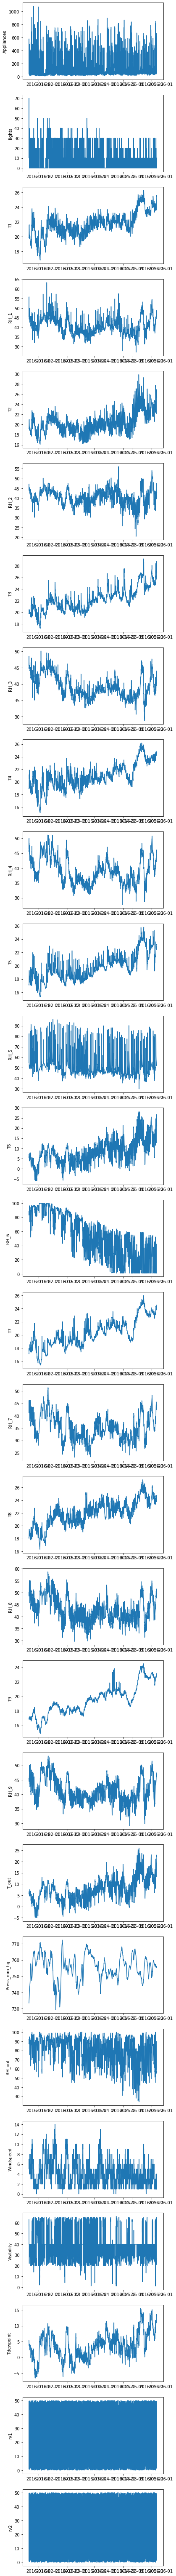

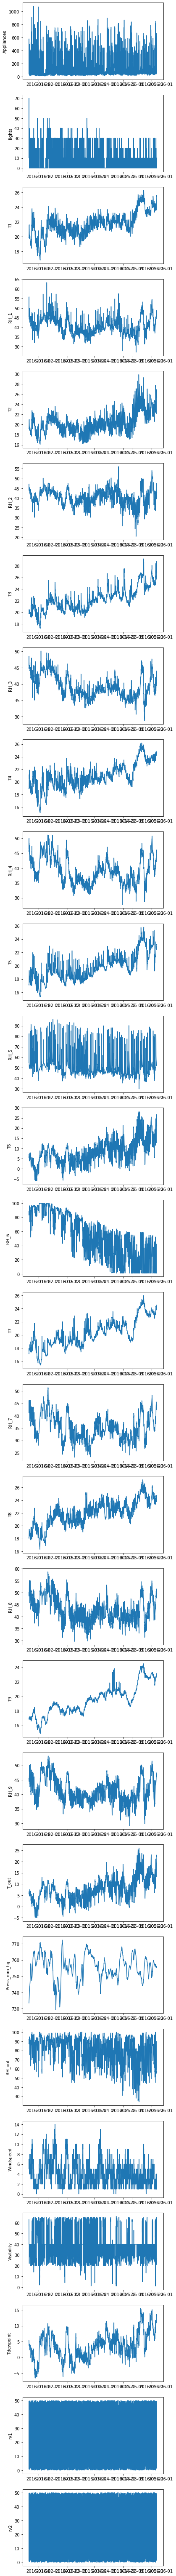

In [2]:
df = pd.read_csv('energydata_complete.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

fig = plot_data(df)
fig

### Taking an n-hour mean

In [3]:
df = df.resample('24h').mean()

### Generating extra features to describe time
weekday: number [0,6]\
weekstatus: binary describing weekend (1) or not (0)\
NSM: Number of Seconds from Midnight

These are used for filtering the data

In [4]:
weekday = np.zeros(len(df))
weekstatus = np.zeros(len(df))
NSM = np.zeros(len(df))
month = np.zeros(len(df))

for i, val in enumerate(df.index):
    weekday[i] = val.weekday()
    weekstatus[i] = (weekday[i] >= 5)  # False for workday, True for weekend
    NSM[i] = (val - val.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()
    month[i] = val.month

df['weekday'] = weekday
df['week status'] = weekstatus
df['NSM'] = NSM
df['month'] = month

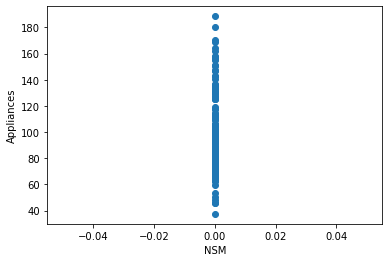

In [5]:
plt.figure()
plt.scatter(df['NSM'],df['Appliances'])
plt.xlabel('NSM')
plt.ylabel('Appliances')
plt.show()

### Filtering data and making training set
Example: Only february, after 16:00 and workday

In [6]:
#df_train = df[(df.index.month==2) & (df['NSM']>=16*3600) & (df['NSM']<24*3600)]
df_train = df[(df.index.month==2)]
df_train = df_train.drop(['weekday', 'week status','month','NSM'], axis=1) # dropping the features used for filtering

# Training data
y = np.array(df_train['Appliances']).reshape(-1,1)
X = np.array(df_train[df_train.columns[1:]])
X, y = standardize(X,y)

### Cross validation parameters

In [7]:
# Creating array of penalties
n_alpha = 100 # Number of penalties
min_alpha = .01 # min penalty
max_alpha = 200 # Maximum penalty
alpha_vals = np.logspace(np.log10(min_alpha),np.log10(max_alpha),n_alpha)
alpha_vals = alpha_vals[::-1] # reversing array (some sklearn standard?)

### Ordinary least squares

In [8]:
reg_lstsq = linear_model.LinearRegression(fit_intercept=False)
beta_ls = reg_lstsq.fit(X,y).coef_

### Lasso

In [9]:
reg = linear_model.Lasso(max_iter = 10000, fit_intercept = False)
beta_lasso, best_beta_lasso, cv_out_lasso, min_alpha_lasso = feature_selection_cv(X, y, alpha_vals, reg)
    
# Best model   
reg_lasso = linear_model.Lasso(alpha=min_alpha_lasso, max_iter = 10000, fit_intercept = False)

### Ridge

In [11]:
reg = linear_model.ElasticNet(max_iter = 10000, l1_ratio=0, fit_intercept = False)

beta_ridge, best_beta_ridge, cv_out_ridge, min_alpha_ridge = feature_selection_cv(X, y, alpha_vals, reg)
        
# Best model
reg_ridge = linear_model.ElasticNet(alpha=min_alpha_ridge, max_iter = 10000, l1_ratio=0.0, fit_intercept = False)

### Elastic net

In [12]:
reg = linear_model.ElasticNet(max_iter = 10000, l1_ratio=0.5, fit_intercept = False)
beta_elnet, best_beta_elnet, cv_out_elnet, min_alpha_elnet = feature_selection_cv(X, y, alpha_vals, reg)

# Best model
reg_elnet = linear_model.ElasticNet(alpha=min_alpha_elnet, max_iter = 10000, l1_ratio=0.5, fit_intercept = False)

### Group lasso

In [13]:
#group_keys= {"T":-1,
#            "RH":-1,
#            "":-1}
group_keys= {"T":1,
            "RH":2,
            "":-1}

groups = []
for var_name in df_train.columns[1:]:
    for key, value in group_keys.items():
        if key in var_name:
            groups.append(value)
            break
# Group the rooms, and outside together
groups=[-1, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 10, 10, 10, 10, -1, -1]
print(*zip(groups, df_train.columns[1:]))

reg = GroupLasso(groups=groups, frobenius_lipschitz=True, subsampling_scheme=1,
                 fit_intercept=False, random_state=0, supress_warning=True, n_iter=10000, tol=0.0001,
    )
group_reg = 0.05
beta_glasso, best_beta_glasso, cv_out_glasso, min_alpha_glasso = feature_selection_cv(X, y, alpha_vals, reg, 
                                                                                      group_reg=group_reg)

(-1, 'lights') (1, 'T1') (1, 'RH_1') (2, 'T2') (2, 'RH_2') (3, 'T3') (3, 'RH_3') (4, 'T4') (4, 'RH_4') (5, 'T5') (5, 'RH_5') (6, 'T6') (6, 'RH_6') (7, 'T7') (7, 'RH_7') (8, 'T8') (8, 'RH_8') (9, 'T9') (9, 'RH_9') (10, 'T_out') (10, 'Press_mm_hg') (10, 'RH_out') (10, 'Windspeed') (10, 'Visibility') (10, 'Tdewpoint') (-1, 'rv1') (-1, 'rv2')


In [14]:
# Best model
reg_gl = GroupLasso(
    groups=groups,
    group_reg=group_reg*min_alpha_glasso,
    l1_reg=(1-group_reg)*min_alpha_glasso,
    frobenius_lipschitz=True,
    subsampling_scheme=1,
    fit_intercept=False,
    random_state=0,
    supress_warning=True,
    n_iter=10000,
    tol=0.0001,
    )

### Plotting coefficients vs lambda

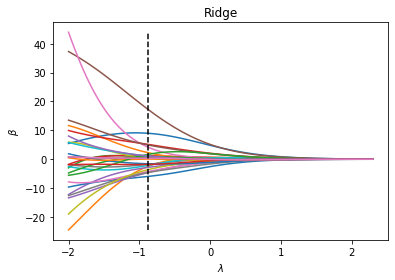

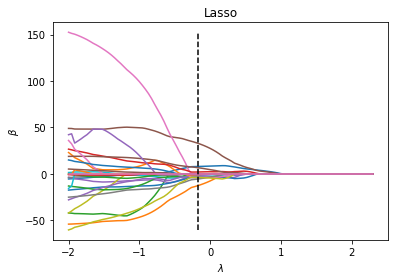

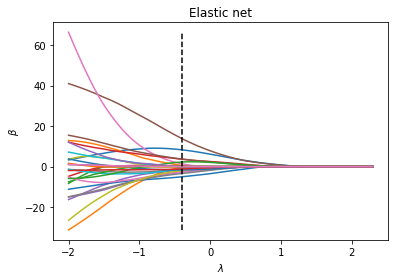

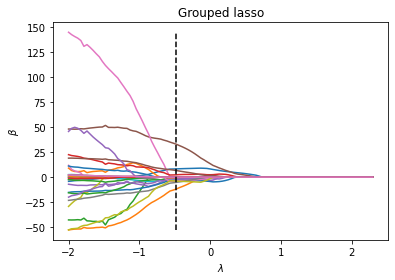

In [15]:
plot_coefficients(beta_ridge, alpha_vals, min_alpha_ridge, name='Ridge')
plot_coefficients(beta_lasso, alpha_vals, min_alpha_lasso, name='Lasso')
plot_coefficients(beta_elnet, alpha_vals, min_alpha_elnet, name='Elastic net')
plot_coefficients(beta_glasso, alpha_vals, min_alpha_glasso, name='Grouped lasso')

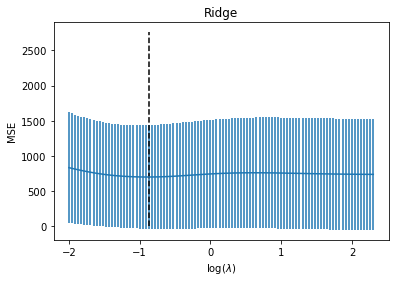

Optimal value of lambda is:  0.135


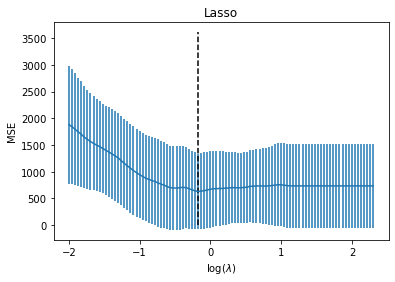

Optimal value of lambda is:  0.668


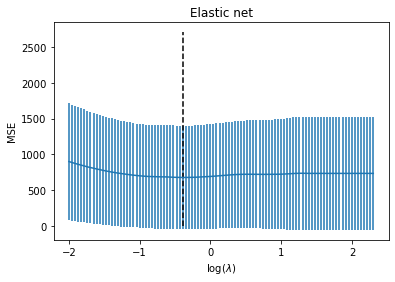

Optimal value of lambda is:  0.405


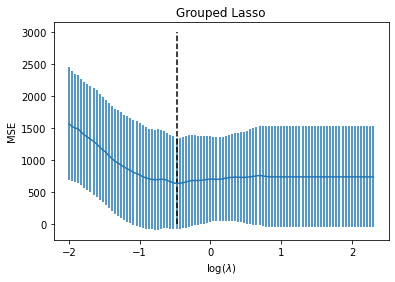

Optimal value of lambda is:  0.332


In [16]:
plot_CV_MSE(alpha_vals, -np.array(cv_out_ridge), min_alpha_ridge, 'Ridge')
plot_CV_MSE(alpha_vals, -np.array(cv_out_lasso), min_alpha_lasso, 'Lasso')
plot_CV_MSE(alpha_vals, -np.array(cv_out_elnet), min_alpha_elnet, 'Elastic net')
plot_CV_MSE(alpha_vals, -np.array(cv_out_glasso), min_alpha_glasso, 'Grouped Lasso')

In [18]:
data = {'Feature': list(df_train.columns[1:])}
df_results = pd.DataFrame(data)
df_results['Least squares'] = beta_ls.T
df_results['Lasso'] = beta_lasso[:,alpha_vals==min_alpha_lasso]
df_results['Ridge'] = beta_ridge[:,alpha_vals==min_alpha_ridge]
df_results['Elastic net'] = beta_elnet[:,alpha_vals==min_alpha_elnet]
df_results['Group Lasso'] = beta_glasso[:,alpha_vals==min_alpha_glasso]
df_results

,Feature,Least squares,Lasso,Ridge,Elastic net,Group Lasso
0,lights,-5.776120,8.028958,8.971135,8.278968,8.172545
1,T1,-145.822612,-12.625089,-2.438151,-0.249461,-12.001202
2,RH_1,-217.986139,-0.000000,0.539393,0.000000,-0.000000
3,T2,157.204266,-0.000000,1.190867,0.099541,-0.000000
4,RH_2,227.277307,-2.011784,-2.807654,-1.712471,-1.895317
5,T3,94.467122,33.073335,17.146150,13.745645,32.837320
6,RH_3,116.414617,0.000000,4.091209,1.354249,0.000000
7,T4,-30.643890,-3.886322,-1.752233,-1.238466,-3.977119
8,RH_4,-103.788047,-0.000000,0.312254,-0.000000,-0.000000
9,T5,-27.882443,-0.626653,-2.098688,-1.075874,-0.879023


### Testing with another month

In [19]:
'''

#df_test = df[(df.index.month==2) & (df['NSM']>=16*3600) & (df['NSM']<24*3600)]

months = [3,4]
regs = [reg_lstsq,reg_lasso,reg_ridge,reg_elnet,reg_glasso]
j = 0

fig, axs = plt.subplots(len(regs),len(months))
fig.set_figheight(15)
fig.set_figwidth(15)

for month in months:

    df_test = df[(df.index.month==month)]
    df_test = df_test.drop(['weekday', 'week status','month','NSM'], axis=1) # dropping the features used for filtering

    # Testing data
    y_t = np.array(df_test['Appliances']).reshape(-1,1)
    X_t = np.array(df_test[df_test.columns[1:]])
    X_t, y_t = standardize(X_t,y_t)
    y_p = reg_glasso.predict(X_t)

    i = 0
    for reg in regs:
        axs[i,j].plot([min(y_p),max(y_p)],[min(y_p),max(y_p)],'k--')
        axs[i,j].scatter(reg.predict(X_t),y_t)
        axs[i,j].grid()
        axs[i,j].axis('equal')
        print('Train score: ',reg.score(X,y))
        print('Test score: ',reg.score(X_t,y_t))
        i+=1
    j+=1
    
for ax in axs.flat:
    ax.set(xlabel='Predicted appliances', ylabel='True appliances')
for ax in axs.flat:
    ax.label_outer()
plt.show()
'''

"\n\n#df_test = df[(df.index.month==2) & (df['NSM']>=16*3600) & (df['NSM']<24*3600)]\n\nmonths = [3,4]\nregs = [reg_lstsq,reg_lasso,reg_ridge,reg_elnet,reg_glasso]\nj = 0\n\nfig, axs = plt.subplots(len(regs),len(months))\nfig.set_figheight(15)\nfig.set_figwidth(15)\n\nfor month in months:\n\n    df_test = df[(df.index.month==month)]\n    df_test = df_test.drop(['weekday', 'week status','month','NSM'], axis=1) # dropping the features used for filtering\n\n    # Testing data\n    y_t = np.array(df_test['Appliances']).reshape(-1,1)\n    X_t = np.array(df_test[df_test.columns[1:]])\n    X_t, y_t = standardize(X_t,y_t)\n    y_p = reg_glasso.predict(X_t)\n\n    i = 0\n    for reg in regs:\n        axs[i,j].plot([min(y_p),max(y_p)],[min(y_p),max(y_p)],'k--')\n        axs[i,j].scatter(reg.predict(X_t),y_t)\n        axs[i,j].grid()\n        axs[i,j].axis('equal')\n        print('Train score: ',reg.score(X,y))\n        print('Test score: ',reg.score(X_t,y_t))\n        i+=1\n    j+=1\n    \nfor a

### Bootstrap CV

In [ ]:
boot_samples = 100# len(df_train)
boot_size = 100 #len(df_train)

reg_lasso = linear_model.Lasso(max_iter=10000, fit_intercept = False)
betas_lasso = bootstrap_loop(X, y, alpha_vals, reg_lasso, b=boot_size, N_samples=boot_samples)

In [ ]:
reg_ridge = linear_model.ElasticNet(alpha=min_alpha_ridge, max_iter = 10000, l1_ratio=0.0, fit_intercept = False)
betas_ridge = bootstrap_loop(X, y, alpha_vals, reg_ridge, b=boot_size, N_samples=boot_samples)

In [ ]:
reg_elnet = linear_model.ElasticNet(alpha=min_alpha_elnet, max_iter=10000, l1_ratio=0.5, fit_intercept = False)
betas_elnet = bootstrap_loop(X, y, alpha_vals, reg_elnet, b=boot_size, N_samples=boot_samples)

In [ ]:
reg_gl = reg_gl = GroupLasso(
    groups=groups,
    group_reg=group_reg*gl_min_alpha,#alpha_vals[i],
    l1_reg=(1-group_reg)*gl_min_alpha,
    frobenius_lipschitz=True,
    #scale_reg="inverse_group_size",
    #scale_reg="inverse_group_size",
    subsampling_scheme=1,
    fit_intercept=False,
    random_state=0,
    supress_warning=True,
    n_iter=10000,
    tol=0.0001,
    )
betas_gl = bootstrap_loop(X, y, alpha_vals, reg_gl, b=boot_size, N_samples=boot_samples, group_reg=group_reg)

In [ ]:
plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.boxplot(betas_lasso,labels=df_train.columns[1:])
plt.xticks(rotation='vertical')
plt.title('Lasso')
plt.show()

plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.boxplot(betas_ridge,labels=df_train.columns[1:])
plt.xticks(rotation='vertical')
plt.title('Ridge')
plt.show()

plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.boxplot(betas_elnet,labels=df_train.columns[1:])
plt.xticks(rotation='vertical')
plt.title('Elastic Net')
plt.show()


plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.boxplot(betas_gl,labels=df_train.columns[1:])
plt.xticks(rotation='vertical')
plt.title('Group Lasso')
plt.show()


In [ ]:
number_of_zeros = np.sum(betas_lasso == 0,axis=0)
y_pos = np.arange(len(df_train.columns[1:]))

# Sorting in descenting order
labels = df_train.columns[1:][number_of_zeros.argsort()][::-1]
number_of_zeros[::-1].sort()

plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.barh(y_pos,number_of_zeros ,align='center', alpha=0.5)
plt.yticks(y_pos, labels)
plt.show()